# WAMIDA Statistical Analysis


This Jupyter notebook displays the statistical processing of the WAMIDA data. Note that the imported data is only available locally on a host machine and this code will not run without the exact same filename accessible by this notebook

## Method:

Analysis has 3 components

**1. Data Prepocessing and Cleaning**

Data is cleaned, with irrelevant data removed, including analysis of Variance Inflation Factor for colinearity and a confusion matrix to highlight low variance variables. Categorical variables are changed into dummy variables for binary categories.

**2. Exploratory Data Analysis**

We can conduct a Mann-Whitney U test for continuous data and Fisher exact test for binary data. We can also compute Pearson correlation coefficients as well. Note that the p-values are not representative of how significant a logistic fit is (this is what we really want in the end), but this can allow us to be exploratory to see which variables are very viable or very unviable for logistic regression fit.

**3. Logistic Regression, Refactoring Low Significance Variables and Re-fitting**

The remaining significant data is placed into a logistic regression model using a maximum likelihood estimate algorithm. The odds ratio of each variable is reported along with P-value The high-p variables are removed and then logistic regression is re-fitted to achieve a higher accruacy fit. Odds ratios can then be reported.

# 1. Preprocessing

In [1]:
# Setup, imports
import math
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from patsy import dmatrices
import statsmodels.api as sm 
import seaborn as sn
from scipy.stats import wilcoxon, pearsonr, mannwhitneyu
import scipy.stats as stats
from tableone import TableOne
from IPython.display import display


matplotlib.rcParams['figure.figsize'] = [40, 20]
import warnings
warnings.filterwarnings('ignore')

C:\Users\rckyh\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\rckyh\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\rckyh\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


# NOTE: ALL 0s and 1s swapped from original table such that 1 = positive for that variable, 0 = negative for that variable

In [2]:
data = pd.read_excel('input.xlsx')
#tempporary 2nd dataframe wiht followup data
dataFollow = data
#dropping irrelevant or incomplete columns
data = data.drop(columns = ['Study ID', 'Deceased', 'New Depression','New Anxiety','Cardiac Rehab',
                           'SF-12','Cardiac Anxiety','MOS Score' ])
dataFollow = dataFollow.drop(columns = ['Study ID', 'Deceased', 'New Depression','New Anxiety','Cardiac Rehab',
                           'SF-12','Cardiac Anxiety','MOS Score'])
data = data.replace({0:1, 1:0})
dataFollow = dataFollow.replace({0:1, 1:0})
#columns with less than 100 non NaN values then drop rows with missing values
data = data.dropna(axis = 1, how='all')
#data = data.dropna(axis = 0)
dataFollow = dataFollow.dropna(axis = 1, how='all')
#dataFollow = dataFollow.dropna(axis=0)

#female data only, have to drop columsn with same values or else crosstab fiails later, can remove with more samples
dataFemale = data.drop(data[data.Sex ==  0].index).drop(columns=['Sex', 'Hx Substance Use Disorder'])
dataFollowFemale = dataFollow.drop(dataFollow[data.Sex ==  0].index).drop(columns=['Sex', 'Hx Substance Use Disorder'])

#Age has a space afterward in the spreadsheet,
cols_num = ['Age ', 'Pack Years', 'Drinks/Week', 'BMI']
data_num = data[cols_num]
data_cat = data.drop(columns = cols_num)
columns = list(data)
dataFemale

Age   Ethnicity  Education Level  Employment  Income (2019)  Married?  \
0      78          1                1           1            1.0         1   
4      58          1                0           0            0.0         0   
7      73          1                1           0            0.0         0   
10     61          1                0           0            0.0         1   
11     65          0                0           0            0.0         0   
13     57          1                1           0            0.0         1   
15     72          1                1           0            1.0         1   
19     68          1                1           0            0.0         0   
20     60          1                1           1            1.0         1   
24     56          1                1           0            0.0         0   
28     84          1                1           0            0.0         1   
29     50          1                0           0            0.0         0   
35     79          1                1           0            0.0         1   
39     72          1                1           0            0.0         0   
40     61          1                1           0            0.0         1   
41     67          1                1           0            0.0         0   
42     68          1                0           0            0.0         1   
44     57          1                1           1            0.0         1   
49     93          1                0           0            0.0         1   
53     84          1                1           0            0.0         1   
61     68          0                0           0            0.0         1   
64     66          1                1           0            1.0         0   
66     53          1                1           0            0.0         0   
71     82          1                0           0            0.0         1   
73     59          0                1           0            1.0         0   
81     68          1                1           0            0.0         0   
84     60          1                0           0            0.0         1   
85     53          1                0           0            0.0         1   
92     54          1                1           0            0.0         0   
95     52          1                0           0            0.0         1   
98     72          1                1           0            0.0         1   
108    72          1                1           0            1.0         1   
110    65          1                1           1            1.0         1   
111    74          1                1           0            0.0         0   
116    73          1                0           0            0.0         0   

     Pack Years  Drinks/Week  Hx Depression  Hx Anxiety   ...  Previous AMI  \
0          17.0            1              0            0  ...             0   
4          40.0            1              0            1  ...             0   
7           1.0            5              0            0  ...             0   
10         32.0           21              0            0  ...             0   
11         10.0            1              1            1  ...             0   
13         60.0            1              0            0  ...             0   
15         14.0            1              0            0  ...             0   
19          1.0           15              0            0  ...             1   
20         20.0            1              0            0  ...             0   
24         17.0            1              1            1  ...             0   
28         15.0            1              0            0  ...             0   
29         30.0            0              0            1  ...             0   
35          0.0            0              0            0  ...             0   
39          1.0            1              0            0  ...             0   
40         

In [15]:
#table1hadsD = TableOne(data, columns=columns, categorical=categorical, pval = True, groupby ='HADS D', smd=True,
#                  htest_name=True)
#table1hadsA = TableOne(data, columns=columns, categorical=categorical, pval = True, groupby ='HADS A', smd=True,
#                  htest_name=True)

C:\Users\rckyh\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Exploratory Data Analysis

## Testing Colinearity with Variance Inflation Factor, colinear variables would not be of statistical value and would be removed for a regression fit 


In [3]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

X = data.iloc[:,:-3].dropna()
calc_vif(X)


variables        VIF
0                        Age   27.265657
1                   Ethnicity  34.609600
2                         Sex   2.345787
3             Education Level   3.061513
4                  Employment   1.535515
5               Income (2019)   1.612204
6                    Married?   2.025748
7                  Pack Years   2.727722
8                 Drinks/Week   1.525945
9   Hx Substance Use Disorder   1.259805
10              Hx Depression   1.674544
11                Hx Anxiety    1.569998
12             Stroke History   1.207479
13               Previous AMI   2.447255
14        Previous Stent/CABG   2.308217
15           High Cholesterol   2.615843
16                   Diabetes   1.771122
17                        BMI  18.199678
18                     HADS D   1.584914
19                     HADS A   1.888658

## Before the first exlusion of features, for instance, BMI was colinear with height and weight. Any collinear variables should be excluded. At this point, all VIF is < 10, which means low collinearity, although some papers argue whether the threshold should be 10 or 5 etc.

## We can visualize pearson correlation of the with a correlation matrix 

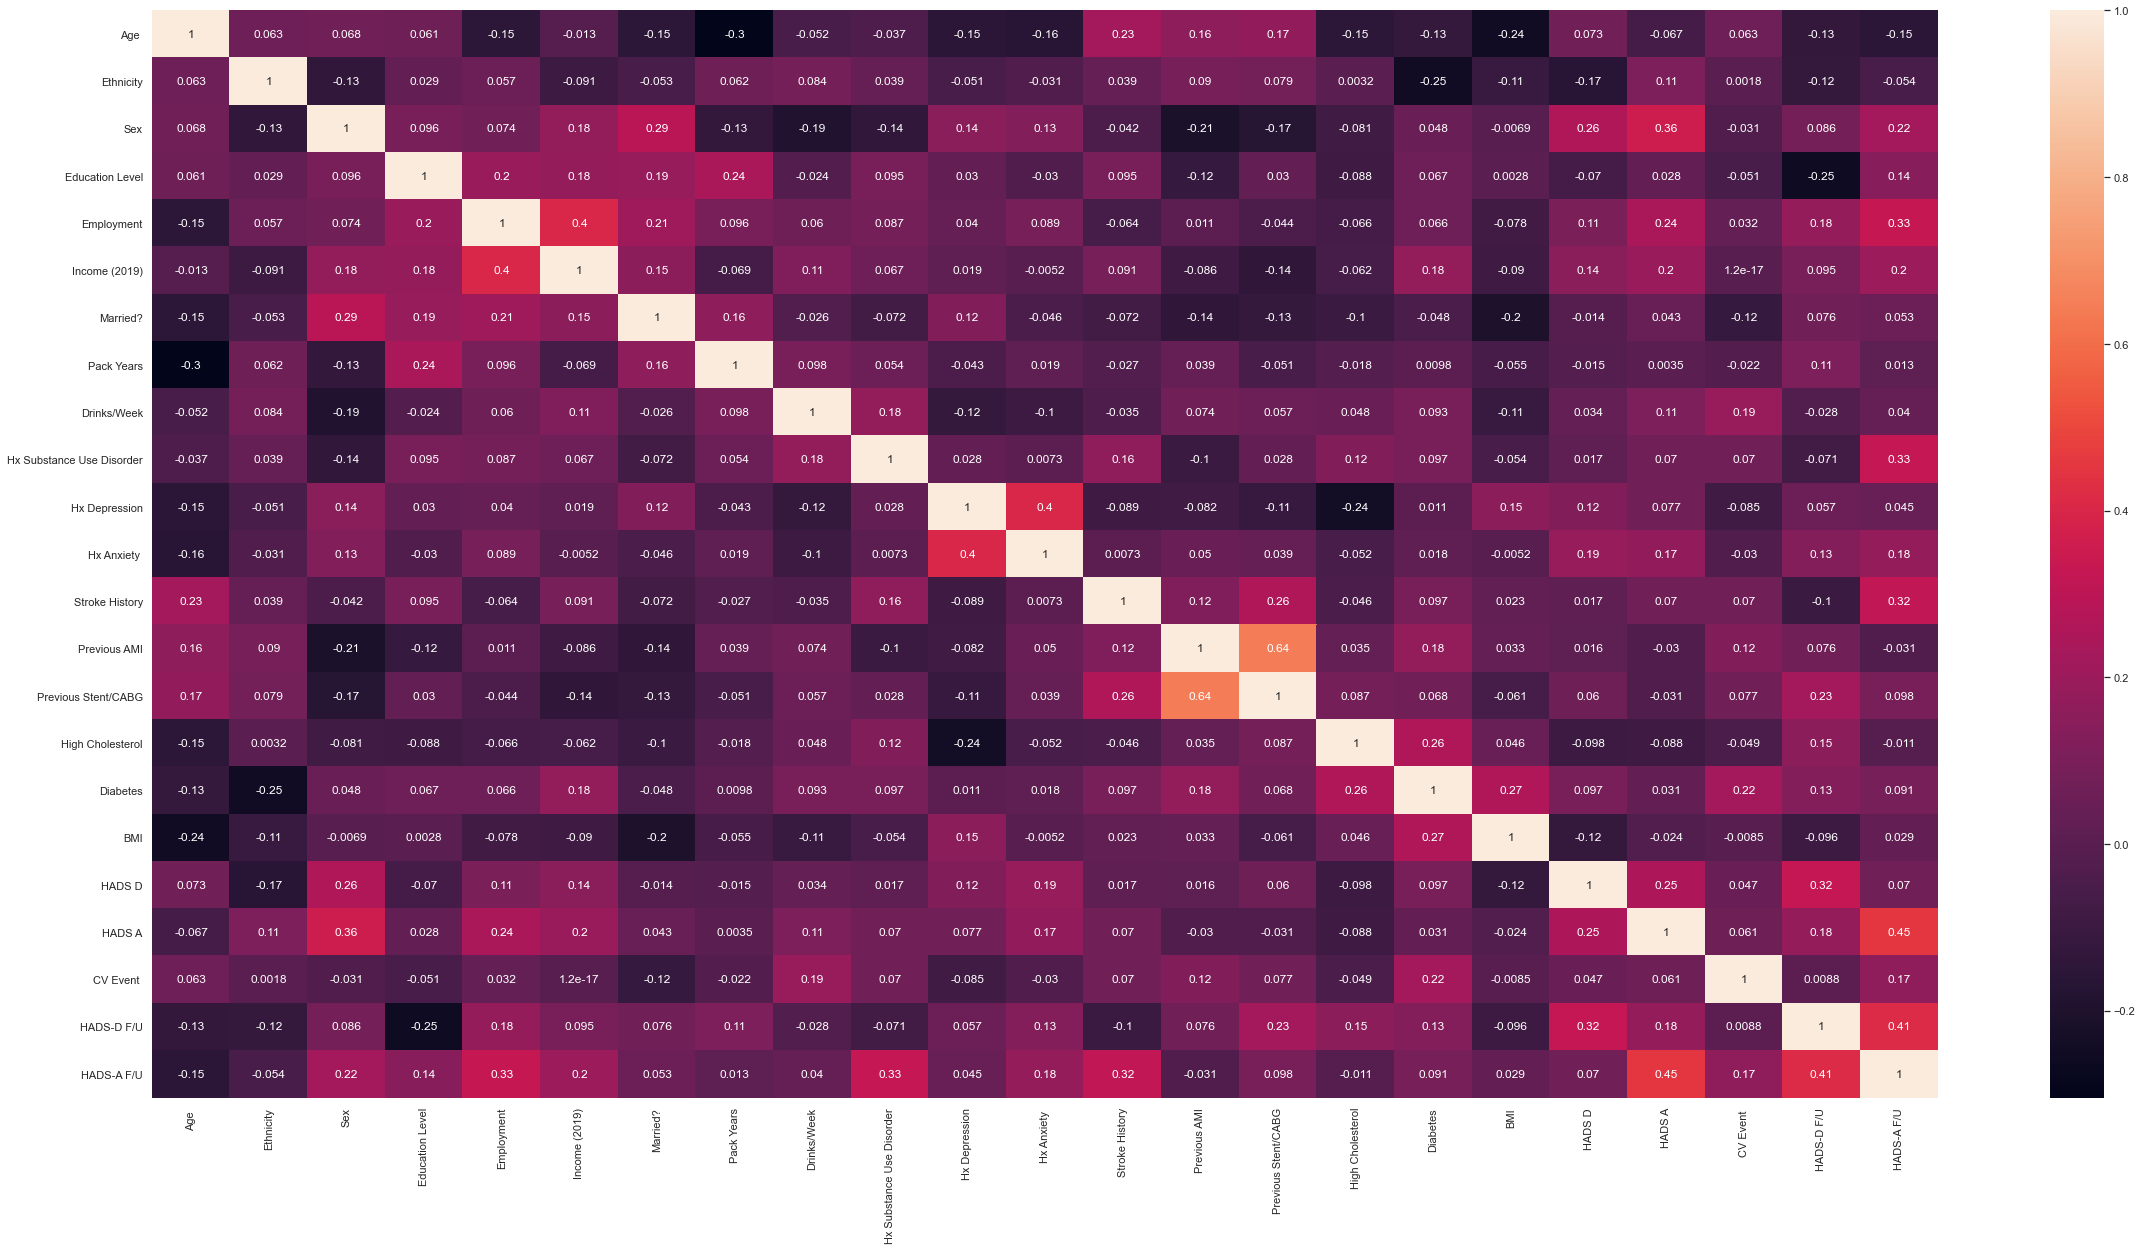

Age   Ethnicity       Sex  Education Level  \
Age                        1.000000   0.063422  0.067831         0.060889   
Ethnicity                  0.063422   1.000000 -0.134364         0.028912   
Sex                        0.067831  -0.134364  1.000000         0.096270   
Education Level            0.060889   0.028912  0.096270         1.000000   
Employment                -0.147640   0.056999  0.073661         0.199348   
Income (2019)             -0.013248  -0.090942  0.178030         0.181336   
Married?                  -0.151485  -0.052776  0.292999         0.186027   
Pack Years                -0.304486   0.061989 -0.129834         0.243494   
Drinks/Week               -0.051644   0.083725 -0.189572        -0.024211   
Hx Substance Use Disorder -0.036525   0.039402 -0.135231         0.095238   
Hx Depression             -0.154446  -0.050774  0.144482         0.029913   
Hx Anxiety                -0.164077  -0.030570  0.125588        -0.029854   
Stroke History             0.229475   0.039402 -0.042160         0.095238   
Previous AMI               0.162927   0.089671 -0.211647        -0.117924   
Previous Stent/CABG        0.171688   0.079472 -0.168562         0.029913   
High Cholesterol          -0.147093   0.003175 -0.080771        -0.088378   
Diabetes                  -0.126135  -0.246683  0.047814         0.066866   
BMI                       -0.244554  -0.108446 -0.006926         0.002786   
HADS D                     0.072653  -0.165011  0.259424        -0.069728   
HADS A                    -0.067498   0.109370  0.357047         0.028037   
CV Event                   0.062692   0.001823 -0.030951        -0.050734   
HADS-D F/U                -0.129012  -0.124111  0.085761        -0.254309   
HADS-A F/U                -0.153315  -0.053548  0.220847         0.140859   

                           Employment  Income (2019)  Married?  Pack Years  \
Age                         -0.147640  -1.324821e-02 -0.151485   -0.304486   
Ethnicity                    0.056999  -9.094160e-02 -0.052776    0.061989   
Sex                          0.073661   1.780296e-01  0.292999   -0.129834   
Education Level              0.199348   1.813358e-01  0.186027    0.243494   
Employment                   1.000000   3.999425e-01  0.212187    0.096031   
Income (2019)                0.399943   1.000000e+00  0.149551   -0.068941   
Married?                     0.212187   1.495508e-01  1.000000    0.161174   
Pack Years                   0.096031  -6.894125e-02  0.161174    1.000000   
Drinks/Week                  0.059969   1.135357e-01 -0.025794    0.097726   
Hx Substance Use Disorder    0.087051   6.728748e-02 -0.071859    0.054173   
Hx Depression                0.040164   1.932007e-02  0.119534   -0.042751   
Hx Anxiety                   0.088725  -5.168114e-03 -0.045980    0.019009   
Stroke History              -0.064008   9.094160e-02 -0.071859   -0.026648   
Previous AMI                 0.010594  -8.619065e-02 -0.136407    0.039221   
Previous Stent/CABG         -0.044468  -1.407605e-01 -0.125345   -0.050712   
High Cholesterol            -0.066025  -6.247974e-02 -0.100893   -0.018090   
Diabetes                     0.065631   1.759041e-01 -0.047840    0.009842   
BMI                         -0.078019  -9.019794e-02 -0.202708   -0.055482   
HADS D                       0.105848   1.447072e-01 -0.013523   -0.014790   
HADS A                       0.241627   1.961161e-01  0.043182    0.003482   
CV Event                     0.031980   1.247427e-17 -0.118579   -0.022197   
HADS-D F/U                   0.179927   9.494949e-02  0.075958    0.110970   
HADS-A F/U                   0.329926   2.006038e-01  0.052868    0.013218   

                           Drinks/Week  Hx Substance Use Disorder  ...  \
Age                          -0.051644                  -0.036525  ...   
Ethnicity                     0.083725                   0.039402  ...   
Sex                          -0.189572                  -0.135231  ...   
Education Lev

In [6]:
corrMatrix = data.corr()
fig = sn.heatmap(corrMatrix, annot=True)
plt.show()
corrMatrix

## Pearson correlation ratios (unused, commented out)

In [8]:
# corrDataHADSA = []
# corrDataHADSD = []
# corrDataCV = []

# for cols in data.columns:
#     (r,p) = pearsonr(data[cols], data['HADS A'])
#     corrDataHADSA.append([cols, r, p])

# for cols in data.columns:
#     (r,p) = pearsonr(data[cols], data['HADS D'])
#     corrDataHADSD.append([cols, r, p])

# for cols in data.columns:
#     (r,p) = pearsonr(data[cols], data['CV Event '])
#     corrDataCV.append([cols, r, p])

# pd.set_option('display.max_rows', None)

# corrDFHADSA = pd.DataFrame(corrDataHADSA, columns = ['Var', 'r','p'])
# corrDFHADSD = pd.DataFrame(corrDataHADSD, columns = ['Var', 'r','p'])
# corrDFCV = pd.DataFrame(corrDataCV, columns = ['Var', 'r','p'])

# print("\n HADS A: \n", corrDFHADSA)
# print("\n HADS D: \n", corrDFHADSD)
# print("\n CV Event: \n", corrDFCV)

## As a preliminary analysis, we can see there are some variables that show some correlation, but the correlation and significance is weak for the most part. This may suggestion that the relationship between the variables to the outcome is nonlinear and linear correlation analysis is insufficient.


# Independent p-values

## We can do some biostat faves and look at MWU values for continuous (comparing to HADS A and HADS D, quasi-continuous, really, since it's all integer data) and Fisher values (comparing to 0/1 of depression or no depression) for binary data. 

## The value of this is that the p-values tell us if the distributions of variables between positive vs. negative outcome has *some significant difference*. This is still valuable to report though there are two mathematical caveats to keep in mind:

1. The p-values look at variables independently. If the relationship can be sufficiently analyzed by linear correlation analysis, then this is great. If the variables are dependent on each other, then there is a chance the traditional p-value may come to a false conclusion. For instance, if pack years is a random predictor by itself but is a strong positive predictor only when drinks/week is within some range, then the p-value would false report that pack years is not significant differently distributed between the outcomes.

2. A p<0.05 (the traditional threshold) tells us the two distributions (e.g. pack years for positive depression vs. pack years for negative depression) has *some significant difference*. This is great for observational statistics ("this variable is important to look at") but requires more work for inferential statistics ("we can use this variable by this weighing formula to predict the outcome") because it doesn't tell us the mathematical nature of the relationship between variables and outcome. Hence, the we can utilize the p-value in two ways: to state that a variable may be significant from an initial linear, independent view and to use as a first-pass filtering of variables if we don't have enough samples to build a model.

# Two-Tailed T-Test for Continuous Data

## For the variables that are unpaired, continuous, Gaussian (theoretically it should be Gaussian by central limit theorem with enough samples), we can do a T-test for association  (Mann-Whitney test can be used if not enough samples, can't do Wilcoxon because variables are different length)

In [11]:
# extraction variable values for positive and negative outcomes

TResults = []
print('T-test p values for continuous data, comparing distributions of variable values for positive vs. negative outcomes: \n')
for cols in data_num.columns:
    posOutcomeAnx = []
    negOutcomeAnx = []
    posOutcomeDep = []
    negOutcomeDep = []
    posOutcomeCV = []
    negOutcomeCV = []
    if ((cols != 'HADS A') and (cols != 'HADS D') and (cols != 'CV Event ')) :
        for row,val in data_num[cols].iteritems():
            variableVal = data_num[cols][row]
            if data_cat['HADS A'][row] == 0:
                negOutcomeAnx.append(variableVal)
            else:
                posOutcomeAnx.append(variableVal)
            if data_cat['HADS D'][row] == 0:
                negOutcomeDep.append(variableVal)
            else:
                posOutcomeDep.append(variableVal)
            if data_cat['CV Event '][row] == 0:
                negOutcomeCV.append(variableVal)
            else:
                posOutcomeCV.append(variableVal)
        uDep, pAnx = stats.ttest_ind(negOutcomeAnx,posOutcomeAnx)
        uDep, pDep = stats.ttest_ind(negOutcomeDep,posOutcomeDep)
        uCV, pCV = stats.ttest_ind(negOutcomeCV, posOutcomeCV)
    
        TResults.append([cols, pAnx, pDep, pCV])

Tdf = pd.DataFrame(TResults, columns = ['cols', 'pAnx','pDep', 'pCV'])
print(Tdf)

T-test p values for continuous data, comparing distributions of variable values for positive vs. negative outcomes: 

          cols      pAnx      pDep       pCV
0         Age   0.467692  0.434302  0.500043
1   Pack Years  0.970149  0.873698  0.811424
2  Drinks/Week  0.235757  0.714839  0.037979
3          BMI  0.792289  0.180102  0.926835


P-values for continuous variables are quite bad. This is not to say the variables aren't significant, just that under the current dataset shows little linear independent significance. We can still use some data science techniques for predictabilitiy later on.

Perhaps because distributions of data are not Gaussian (they should be if we have enough samples under CLT) as that signifies not enough data has been collected to analyze these variables using techniques that rely on randomizations being balance under a Gaussian distribution (i.e. almost all p-value tests)

# For the binary variables, we use Fisher's Exact Test

## We have to create contingency tables for each variables with respect to the outcome (binary anxiety or binary depression outcomes), then compute the Fisher exact test odds ratio and p-value

In [12]:
print('Fisher exact test values: \n')

fisherResults =[ ]

for cols in data_cat.columns:
    data_crosstabAnx = pd.crosstab(data_cat[cols],data_cat['HADS A'])
    data_crosstabDep = pd.crosstab(data_cat[cols],data_cat['HADS D'])
    data_crosstabCV = pd.crosstab(data_cat[cols],data_cat['CV Event '])
    orAnx, pAnx = stats.fisher_exact(data_crosstabAnx)
    orDep, pDep = stats.fisher_exact(data_crosstabDep)
    orCV, pCV = stats.fisher_exact(data_crosstabCV)
    
    fisherResults.append([cols, orAnx, pAnx, orDep, pDep, orCV, pCV])
    
fisherdf = pd.DataFrame(fisherResults, columns = ['cols', 'orAnx', 'pAnx','orDep','pDep', 'orCV','pCV'])
print(fisherdf)

Fisher exact test values: 

                         cols     orAnx          pAnx     orDep          pDep  \
0                   Ethnicity       inf  5.709994e-01  0.187500  1.328716e-01   
1                         Sex  5.384615  3.061013e-04  3.932367  1.268568e-02   
2             Education Level  1.140000  8.324672e-01  0.689655  4.671470e-01   
3                  Employment  5.250000  1.674324e-02  2.294118  3.702436e-01   
4               Income (2019)  3.521739  7.060245e-02  2.750000  2.170718e-01   
5                    Married?  1.225806  6.649790e-01  0.927350  1.000000e+00   
6   Hx Substance Use Disorder  2.023810  6.001639e-01  1.236842  1.000000e+00   
7               Hx Depression  1.583333  3.926162e-01  2.179487  1.863765e-01   
8                 Hx Anxiety   2.472527  1.004773e-01  2.979487  5.661898e-02   
9              Stroke History  2.023810  6.001639e-01  1.236842  1.000000e+00   
10               Previous AMI  0.835294  1.000000e+00  1.111111  1.000000e+00   


## P-values are all over the place, especially for the binary variables likely due to low frequency and the algorithm thinks it's all due to chance, with the exception of a few variables (sex, Hx Anxiety maybe). Likely more samples are needed to elicit a meaningful Fisher test.

## We can also do a basic linear odds ratio calculation

In [14]:
def getOddsRatios(data, outcome):
    
    ORList = []
    
    for cols in data.columns:

        data_crosstab = pd.crosstab(data[cols],data[outcome])
        tp = data_crosstab.iloc[1][1]
        tn = data_crosstab.iloc[0][0]
        fp = data_crosstab.iloc[1][0]
        fn = data_crosstab.iloc[0][1]
        if(tp == 0 or tn == 0 or fp == 0 or fn == 0):
            tp = tp + 0.5
            tn = tn + 0.5
            fp = fp + 0.5
            fn = fn + 0.5
        
        linOR = (tp*tn)/(fp*fn)
        SE = math.sqrt(1/tp + 1/tn + 1/fp + 1/fn)
        z = math.log(linOR)/SE
        CILow = math.exp(math.log(linOR) - 1.96*SE)
        CIHigh = math.exp(math.log(linOR) + 1.96*SE)
        p=stats.norm.sf(abs(z))*2
        
        ORList.append([cols, linOR, CILow, CIHigh, p])
        
    return ORList

In [15]:
ORDep = getOddsRatios(data, 'HADS D')
ORAnx = getOddsRatios(data, 'HADS A')
ORCV = getOddsRatios(data, 'CV Event ')
ORDepF = getOddsRatios(dataFemale, 'HADS D')
ORAnxF = getOddsRatios(dataFemale, 'HADS A')
ORCVF = getOddsRatios(dataFemale, 'CV Event ')

ORDepFollow = getOddsRatios(dataFollow, 'HADS-D F/U')
ORAnxFollow = getOddsRatios(dataFollow, 'HADS-A F/U')
ORDepFollowF = getOddsRatios(dataFollowFemale, 'HADS-D F/U')
ORAnxFollowF = getOddsRatios(dataFollowFemale, 'HADS-A F/U')

ORDepDF = pd.DataFrame(ORDep, columns = ['col','OR','CILow','CIHigh','p'])
ORAnxDF = pd.DataFrame(ORAnx, columns = ['col','OR','CILow','CIHigh','p'])
ORCVDF = pd.DataFrame(ORCV, columns = ['col','OR','CILow','CIHigh','p'])
ORDepDFFollow = pd.DataFrame(ORDepFollow, columns = ['col','OR','CILow','CIHigh','p'])
ORAnxDFFollow = pd.DataFrame(ORAnxFollow, columns = ['col','OR','CILow','CIHigh','p'])

#female only
ORDepDFF = pd.DataFrame(ORDepF, columns = ['col','OR','CILow','CIHigh','p'])
ORAnxDFF = pd.DataFrame(ORAnxF, columns = ['col','OR','CILow','CIHigh','p'])
ORCVDFF = pd.DataFrame(ORCVF, columns = ['col','OR','CILow','CIHigh','p'])
ORDepDFFollowF = pd.DataFrame(ORDepFollowF, columns = ['col','OR','CILow','CIHigh','p'])
ORAnxDFFollowF = pd.DataFrame(ORAnxFollowF, columns = ['col','OR','CILow','CIHigh','p'])


print('HADS D: \n')
print(ORDepDF)
print('HADS A: \n')
print(ORAnxDF)
print('CV Event: \n')
print(ORCVDF)
print('HADS D Followup: \n')
print(ORDepDFFollow)
print('HADS A Followup: \n')
print(ORAnxDFFollow)


HADS D: 

                          col           OR       CILow         CIHigh  \
0                        Age      1.000000    0.010819      92.427644   
1                   Ethnicity     0.187500    0.024783       1.418562   
2                         Sex     3.932367    1.450248      10.662668   
3             Education Level     0.689655    0.262833       1.809607   
4                  Employment     2.294118    0.539056       9.763313   
5               Income (2019)     2.750000    0.739674      10.224100   
6                    Married?     0.927350    0.338953       2.537160   
7                  Pack Years     1.000000    0.010819      92.427644   
8                 Drinks/Week     1.604167    0.178571      14.410816   
9   Hx Substance Use Disorder     1.236842    0.130869      11.689395   
10              Hx Depression     2.179487    0.677532       7.010978   
11                Hx Anxiety      2.979487    1.021131       8.693637   
12             Stroke History     1.23684

## 3. Initial Attempt at Logistic Regression

## First removing colinear variables, similar to above. Note that categorical variables are not defined for VIF, colinearity is not well understood for those

In [31]:
data_final = data.drop(columns=['HADS-D F/U','HADS-A F/U'])
data_final.columns

Index(['Age ', 'Ethnicity', 'Sex', 'Education Level', 'Employment',
       'Income (2019)', 'Married?', 'Pack Years', 'Drinks/Week',
       'Hx Substance Use Disorder', 'Hx Depression', 'Hx Anxiety ',
       'Stroke History', 'Previous AMI', 'Previous Stent/CABG',
       'High Cholesterol', 'Diabetes', 'BMI', 'HADS D', 'HADS A', 'CV Event '],
      dtype='object')

## Removing low-variance variables (not needed atm)

In [32]:
# from sklearn.feature_selection import VarianceThreshold

# def variance_threshold_selector(data, threshold=0.5):
#     selector = VarianceThreshold(threshold)
#     selector.fit(data)
#     return data[data.columns[selector.get_support(indices=True)]]

# # min_variance = .9 * (1 - .9)  # You can play here with different values.
# X = data_final
# min_variance = 0.1
# high_var_cols = variance_threshold_selector(X, min_variance) 
# print('columns remaining: ', high_var_cols.columns )
# print(len(high_var_cols.columns))
# X_low_var_removed = data_final[high_var_cols.columns]
# X_low_var_removed.columns

# Logistic Regression (odds ratios are adjusted for all other covariates)

Remember to to e^(coefficient) to get odds ratios)

# For Anxiety:

In [45]:
def fitLogReg(data, outcome):
    maxParams = math.floor(len(data)/10)
    #dropping other outcomes
    outcomeCol = data[outcome]
    data = data.drop(columns = ['HADS A','HADS D','CV Event '])
    data[outcome] = outcomeCol
    
    #first logit fit
    y = data[outcome]
    X = data.drop(columns = [outcome])
    logit_model=sm.Logit(y,X)
    result=logit_model.fit()
    print(result.summary2())
    
    #refitting with feature selection
    print('Refitting after feature selection \n')
    toDrop = len(X.columns) - maxParams
    LRresult = (result.summary2().tables[1])
    resultDropped = LRresult.drop(LRresult['P>|z|'].nlargest(toDrop).index)
    cols = resultDropped.index
    
    XFiltered = data[cols]
    logit_model=sm.Logit(y,XFiltered)
    result=logit_model.fit()
    print(result.summary2())
    LRresult = (result.summary2().tables[1])
    
    return LRresult

In [46]:
data_final = data_final.dropna(axis=0)
data_final

Age   Ethnicity  Sex  Education Level  Employment  Income (2019)  \
0      78          1  1.0                1           1            1.0   
1      67          1  0.0                1           0            0.0   
2      80          1  0.0                0           0            0.0   
3      56          1  0.0                0           0            0.0   
4      58          1  1.0                0           0            0.0   
..    ...        ...  ...              ...         ...            ...   
113    49          1  0.0                0           1            0.0   
114    70          1  0.0                0           0            0.0   
115    65          1  0.0                1           0            0.0   
116    73          1  1.0                0           0            0.0   
117    71          1  0.0                0           0            0.0   

     Married?  Pack Years  Drinks/Week  Hx Substance Use Disorder  ...  \
0           1        17.0            1                          0  ...   
1           1        26.0           10                          0  ...   
2           0        30.0           25                          0  ...   
3           1        40.0            1                          0  ...   
4           0        40.0            1                          0  ...   
..        ...         ...          ...                        ...  ...   
113         0        30.0            1                          0  ...   
114         0        15.0            7                          0  ...   
115         0        35.0            1                          1  ...   
116         0         1.0            1                          0  ...   
117         1        25.0            1                          0  ...   

     Hx Anxiety   Stroke History  Previous AMI  Previous Stent/CABG  \
0              0               0             0                    0   
1              0               0             1                    1   
2              0               0             0                    0   
3              0               0             0                    0   
4              1               0             0                    0   
..           ...             ...           ...                  ...   
113            0               0             1                    0   
114            1               0             1                    1   
115            1               0             0                    0   
116            1               0             0                    0   
117            0               0             0                    0   

     High Cholesterol  Diabetes        BMI  HADS D  HADS A  CV Event   
0                   0         0  24.409722       1       1          0  
1                   0         0  19.523904       0       0          0  
2                   0         0  22.521329       0       1          1  
3                   1         0  24.342105       0       0          0  
4                   1         0  26.449879       1       1          0  
..                ...       ...        ...     ...     ...        ...  
113                 1         1  30.893555       0       1          1  
114                 1         0  23.803965       1       1          0  
115                 1         1  24.363579       1       0          0  
116                 1         0  22.312012       0       0          1  
117                 1         0  22.500865       0       0          0  

[115 rows x 21 columns]

In [50]:
print('\n \n anxiety \n')
LRAnx = fitLogReg(data_final, 'HADS A')
print('\n \n depression \n')
LRDep = fitLogReg(data_final, 'HADS D')
print('\n \n cv event \n')
LRCV = fitLogReg(data_final, 'CV Event ')


 
 anxiety 

Optimization terminated successfully.
         Current function value: 0.423272
         Iterations 7
                             Results: Logit
Model:                  Logit               Pseudo R-squared:    0.250   
Dependent Variable:     HADS A              AIC:                 133.3525
Date:                   2022-05-04 17:01    BIC:                 182.7613
No. Observations:       115                 Log-Likelihood:      -48.676 
Df Model:               17                  LL-Null:             -64.942 
Df Residuals:           97                  LLR p-value:         0.012917
Converged:              1.0000              Scale:               1.0000  
No. Iterations:         7.0000                                           
-------------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------------------
Age                       

# Comments on logisitic regression:

We start to see some variables have significance in the z-score range, especially Sex and potentially Income and Diabetes. More data is definitely needed but there is an odds ratio correalation that we can draw from this. Remember that to get the odds ratio you need e^(coefficient).

# Classification and Regression Tree Approach

## The problem proposed (e.g. need variables to associated with an outcome) is a classic machine learning classification problem. The clinical goal proposed (e.g. come up with some screening algorithm, with variables of unknown importance) is fit for a parametric nonlinear model with feature selection (i.e. not logistic regression). Below is an example of one of these models: a decision tree optimized by the CART algorithm. It is not state of the art (random forest would be a "modern" form of it, but can be explored to test predictability of the variables. One bonus is that the result is like a "flowchart", which is familiar to clinical experts, rather than an equation.).

In [81]:
from sklearn.tree import DecisionTreeClassifier  
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix, roc_auc_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import RocCurveDisplay, auc
import graphviz
from graphviz import Source
from IPython.display import SVG
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
%matplotlib inline

In [137]:
def fitDT(data, outcome, max_features = 10, k = 5, max_depth = 6):

    #performing select k best by mutual info score, dropping all outcome columns
    #can chang e later if we want to keep outcome columns as an independent variable
    X = data.drop(columns = ['HADS D', 'HADS A', 'CV Event '])
    y = data[outcome]
    selector = SelectKBest(mutual_info_classif, k = max_features)
    selector.fit(X, y)
    

    # Get columns to keep and create new dataframe with those only
    cols = selector.get_support(indices=True)
    data = X.iloc[:,cols]
    data[outcome] = y

    y = data[outcome].astype(int)
    X = data.drop(columns = [outcome])
    kf=StratifiedKFold(n_splits=k, random_state=42, shuffle=True)

    sens = []
    spec = []
    acc = []
    # have to name auc aucVal beacuse auc is the library name
    aucVal = []
    imps = []
    i = 1
    tprs = []
    aucs = []
    fig, ax = plt.subplots(figsize=(6,3.75))
    mean_fpr = np.linspace(0, 1, 100)
    
    print(data.columns)
    for trainIdx, testIdx in kf.split(X,y):

        XTrain, XTest = X.iloc[trainIdx], X.iloc[testIdx]
        yTrain, yTest=y.iloc[trainIdx], y.iloc[testIdx]

        #building model
        tree = DecisionTreeClassifier(max_depth=max_depth,random_state=42)
        tree.fit(XTrain,yTrain)

        # feature importances
        imps.append(tree.feature_importances_)
        #metrics
        preds = tree.predict(XTest)
        tn, fp, fn, tp = confusion_matrix(yTest, preds).ravel()
        sens.append(tp/(tp+fn))
        spec.append(tn/(tn+fp))
        acc.append((tp+tn)/(tp+tn+fp+fn))
        aucVal.append(roc_auc_score(yTest, tree.predict(XTest)))
        
        viz = RocCurveDisplay.from_estimator(
        tree,
        XTest,
        yTest,
        name="ROC fold {}".format(i),
        alpha=0.5,
        lw=1,
        ax=ax,
            
        )
        
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        
        i = i+1

    # plotting AUC ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
    )
    ax.legend(loc="lower right")
    plt.show()

    #showi ndecision tree graphic
    
    filename = outcome + ".dot"
    graph = Source(export_graphviz(tree, out_file=filename, class_names=['Positive ' +
                                                                         outcome,'Negative ' + outcome], feature_names=X.columns, impurity=False, filled=True))
    #show decision tree, only do this if graphviz is installed to system PATH
    #SVG(graph.pipe(format='svg'))
    return sens, spec, acc, aucVal, imps

Index(['Ethnicity', 'Sex', 'Employment', 'Hx Depression', 'Hx Anxiety ',
       'Stroke History', 'Previous AMI', 'High Cholesterol', 'HADS A'],
      dtype='object')


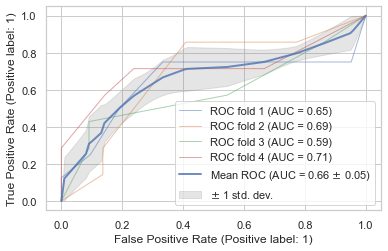

Index(['Ethnicity', 'Income (2019)', 'Pack Years', 'Drinks/Week',
       'Hx Substance Use Disorder', 'Hx Anxiety ', 'High Cholesterol', 'BMI',
       'HADS D'],
      dtype='object')


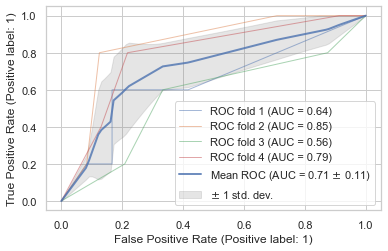

Index(['Sex', 'Education Level', 'Married?', 'Pack Years', 'Hx Anxiety ',
       'Stroke History', 'Previous AMI', 'Previous Stent/CABG', 'CV Event '],
      dtype='object')


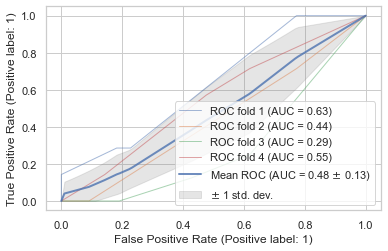

Outcome  Sens Mean  Sens Std  Spec Mean  Spec Std  Acc Mean   Acc Std  \
0    HADS A   0.375000  0.170346   0.871212  0.052453  0.748153  0.025855   
1    HADS D   0.300000  0.173205   0.841938  0.045926  0.748153  0.043099   
2  CV Event   0.071429  0.123718   0.942641  0.074440  0.721983  0.032471   

   Auc mean   Auc std  
0  0.623106  0.065569  
1  0.570969  0.085057  
2  0.507035  0.027693

In [147]:
results= []
max_features = 8
k_folds = 4
max_depth = 4
sensAnx, specAnx, accAnx, aucValAnx, impsAnx = fitDT(data_final, 'HADS A', max_features = max_features, k = k_folds, max_depth = max_depth)
sensDep, specDep, accDep, aucValDep, impsDep = fitDT(data_final, 'HADS D', max_features = max_features, k = k_folds, max_depth = max_depth)
sensCV, specCV, accCV, aucValCV, impsCV = fitDT(data_final, 'CV Event ', max_features = max_features, k = k_folds, max_depth = max_depth)


results.append(['HADS A', np.mean(sensAnx), np.std(sensAnx), np.mean(specAnx), np.std(specAnx), 
               np.mean(accAnx), np.std(accAnx), np.mean(aucValAnx), np.std(aucValAnx)])
results.append(['HADS D', np.mean(sensDep), np.std(sensDep), np.mean(specDep), np.std(specDep), 
               np.mean(accDep), np.std(accDep), np.mean(aucValDep), np.std(aucValDep)])
results.append(['CV Event', np.mean(sensCV), np.std(sensCV), np.mean(specCV), np.std(specCV), 
               np.mean(accCV), np.std(accCV), np.mean(aucValCV), np.std(aucValCV)])

resultsDF = pd.DataFrame(results, columns = ['Outcome', 'Sens Mean', 'Sens Std', 'Spec Mean', 'Spec Std',
                                            'Acc Mean', 'Acc Std', 'Auc mean', 'Auc std'])
resultsDF


In [ ]:
# # Print the features and their importance for the  decision tree
# print('Feature importances: {}'.format(treeAnx.feature_importances_))
# type(treeAnx.feature_importances_)

# #Plot feature importance
# n_feature = features.shape[1]
# fig = plt.figure(figsize=(10,8))
# plt.barh(range(n_feature), treeAnx.feature_importances_, align='center')
# plt.yticks(np.arange(n_feature), features)
# plt.xlabel('Feature Importance')
# plt.ylabel('Feature')
# plt.show()

# CART Summary:

## Even with the limited sample size, the machine learning approach shows decent accuracy (in this case accuracy is measured by the Jaccard index) of ~0.85, defined below.

<img src = "https://wikimedia.org/api/rest_v1/media/math/render/svg/eaef5aa86949f49e7dc6b9c8c3dd8b233332c9e7" />

## Excellent models have ~0.90 accuracy so this is a good start. Further complex models like a random forest may provide greater accuracies in the future but requires refining of the input features to prevent overfitting.

# ----------------------------------------------------------------------------------------------------
# TL;DR of Results

## Linear Correlation Ratios

In [65]:
corrDFHADSA

Var         r         p
0                              Age  -0.028955  0.759749
1                         Ethnicity -0.087131  0.356628
2                               Sex  0.395922  0.000013
3                   Education Level  0.074754  0.429257
4                        Employment  0.285304  0.002092
5                     Income (2019)  0.257599  0.005658
6                    Marital Status  0.024939  0.792253
7                           Smoked  -0.128527  0.172938
8         Hx Substance Use Disorder  0.093535  0.322249
9                     Hx Depression  0.075699  0.423426
10                       Hx Anxiety  0.145704  0.121907
11        More Anxious During COVID  0.172392  0.066636
12  Time to Care Impacted by COVID?  0.335148  0.000267
13                    COVID Lonely?  0.269402  0.003749
14                           Stroke  0.014149  0.881225
15                     Previous AMI -0.033100  0.726627
16              Previous Stent/CABG -0.043331  0.647118
17                 High Cholesterol -0.072909  0.440763
18                         Diabetes  0.050510  0.593552
19                           HADS D  0.232708  0.012718
20                           HADS A  1.000000  0.000000
21                       Pack Years -0.099500  0.292213
22                      Drinks/Week  0.014591  0.877543
23                              BMI  0.065252  0.490348

In [66]:
corrDFHADSD

Var         r         p
0                              Age   0.051804  0.584115
1                         Ethnicity  0.260235  0.005170
2                               Sex  0.200022  0.032865
3                   Education Level -0.081387  0.389332
4                        Employment  0.154497  0.100741
5                     Income (2019)  0.136457  0.147705
6                    Marital Status -0.035224  0.709851
7                           Smoked  -0.010976  0.907728
8         Hx Substance Use Disorder -0.083368  0.377856
9                     Hx Depression  0.128447  0.173208
10                       Hx Anxiety  0.161593  0.085864
11        More Anxious During COVID  0.074315  0.431978
12  Time to Care Impacted by COVID?  0.066844  0.479799
13                    COVID Lonely? -0.019575  0.836228
14                           Stroke  0.066804  0.480062
15                     Previous AMI  0.082795  0.381154
16              Previous Stent/CABG  0.055596  0.556855
17                 High Cholesterol -0.136600  0.147277
18                         Diabetes  0.127625  0.175998
19                           HADS D  1.000000  0.000000
20                           HADS A  0.232708  0.012718
21                       Pack Years -0.046978  0.619658
22                      Drinks/Week  0.060143  0.525003
23                              BMI -0.067890  0.472937

In [134]:
corrDFCV

C:\Users\rckyh\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Var         r         p
0                        Age  -0.052909  0.574402
1                   Ethnicity -0.030587  0.745556
2                         Sex -0.025183  0.789351
3             Education Level -0.056199  0.550803
4                  Employment  0.033988  0.718400
5               Income (2019)  0.015393  0.870303
6                    Married? -0.117679  0.210374
7                  Pack Years  0.038355  0.684034
8                 Drinks/Week -0.186094  0.046451
9   Hx Substance Use Disorder  0.072575  0.440826
10              Hx Depression -0.072607  0.440629
11                Hx Anxiety  -0.055126  0.558449
12             Stroke History -0.000950  0.991958
13               Previous AMI  0.088335  0.347844
14        Previous Stent/CABG  0.040228  0.669483
15           High Cholesterol -0.025075  0.790240
16                   Diabetes  0.210252  0.024111
17                        BMI -0.003403  0.971209
18                     HADS D  0.050532  0.591738
19                     HADS A  0.031676  0.736825
20                  CV Event   1.000000  0.000000

## Mann-Whitney U Test for p-values of Continuous Data

In [135]:
MWUdf

C:\Users\rckyh\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


cols      pAnx      pDep       pCV
0         Age   0.259645  0.179955  0.378535
1   Pack Years  0.463727  0.498514  0.455984
2  Drinks/Week  0.220637  0.471741  0.265769
3          BMI  0.430974  0.104176  0.293143

## Fisher Exact Test for Binary Data

In [136]:
fisherdf

C:\Users\rckyh\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


cols     orAnx          pAnx     orDep          pDep  \
0                   Ethnicity       inf  5.707053e-01  0.095745  7.772220e-02   
1                         Sex  5.750000  2.599733e-04  3.826087  1.307574e-02   
2             Education Level  1.121528  8.315916e-01  0.727273  6.215327e-01   
3                  Employment  5.347826  1.589783e-02  2.218487  3.749091e-01   
4               Income (2019)  4.226087  2.857988e-02  3.142857  9.771037e-02   
5                    Married?  1.252372  6.601365e-01  0.882479  1.000000e+00   
6   Hx Substance Use Disorder  2.049383  5.987448e-01  1.197368  1.000000e+00   
7               Hx Depression  1.778656  3.648014e-01  2.305556  1.721662e-01   
8                 Hx Anxiety   2.349206  1.535716e-01  3.396450  4.516861e-02   
9              Stroke History  0.988095  1.000000e+00  1.614035  5.395070e-01   
10               Previous AMI  0.649412  5.854433e-01  1.147059  7.593825e-01   
11        Previous Stent/CABG  0.593407  5.548930e-01  1.576923  4.925024e-01   
12           High Cholesterol  0.740278  5.251387e-01  0.600000  3.349842e-01   
13                   Diabetes  1.058824  1.000000e+00  1.966387  2.285621e-01   
14                     HADS D  4.000000  9.303655e-03       inf  8.591802e-23   
15                     HADS A       inf  7.323191e-28  4.000000  9.303655e-03   
16                  CV Event   1.179138  8.058399e-01  1.341615  5.804715e-01   

        orCV           pCV  
0   0.666667  1.000000e+00  
1   0.879121  1.000000e+00  
2   0.771429  6.655294e-01  
3   1.302198  7.109956e-01  
4   1.125000  1.000000e+00  
5   0.555102  2.686980e-01  
6   2.049383  5.987448e-01  
7   0.593407  5.548930e-01  
8   0.700000  7.777332e-01  
9   0.988095  1.000000e+00  
10  1.636364  4.058923e-01  
11  1.284722  7.630365e-01  
12  0.890909  8.323459e-01  
13  2.955466  3.261919e-02  
14  1.341615  5.804715e-01  
15  1.179138  8.058399e-01  
16       inf  7.323191e-28

## Linear Odds Ratios for depression, anxiety, CV event, f/u depression, and f/u anxiety

In [28]:
df_list = [ORDepDF,ORAnxDF,ORCVDF,ORDepDFFollow,ORAnxDFFollow]
titles = ['Depression', 'Anxiety', 'CV Event', 'Depression F/U', 'Anxiety F/U']
j = 0
for i in df_list:
    print(titles[j])
    j = j +1
    display(i)

Depression


col           OR       CILow         CIHigh  \
0                        Age      1.000000    0.010819      92.427644   
1                   Ethnicity     0.187500    0.024783       1.418562   
2                         Sex     3.932367    1.450248      10.662668   
3             Education Level     0.689655    0.262833       1.809607   
4                  Employment     2.294118    0.539056       9.763313   
5               Income (2019)     2.750000    0.739674      10.224100   
6                    Married?     0.927350    0.338953       2.537160   
7                  Pack Years     1.000000    0.010819      92.427644   
8                 Drinks/Week     1.604167    0.178571      14.410816   
9   Hx Substance Use Disorder     1.236842    0.130869      11.689395   
10              Hx Depression     2.179487    0.677532       7.010978   
11                Hx Anxiety      2.979487    1.021131       8.693637   
12             Stroke History     1.236842    0.130869      11.689395   
13               Previous AMI     1.111111    0.331626       3.722772   
14        Previous Stent/CABG     1.500000    0.437064       5.147982   
15           High Cholesterol     0.589744    0.221640       1.569200   
16                   Diabetes     1.781955    0.605401       5.245061   
17                        BMI     1.000000    0.010819      92.427644   
18                     HADS D  8077.000000  155.711405  418966.928975   
19                     HADS A     3.900000    1.427840      10.652457   
20                  CV Event      1.321429    0.457160       3.819615   
21                 HADS-D F/U     6.666667    1.395438      31.849807   
22                 HADS-A F/U     1.535714    0.343947       6.856929   

           p  
0   1.000000  
1   0.104943  
2   0.007136  
3   0.450289  
4   0.261127  
5   0.131066  
6   0.883226  
7   1.000000  
8   0.673073  
9   0.852849  
10  0.191232  
11  0.045687  
12  0.852849  
13  0.864387  
14  0.519276  
15  0.290233  
16  0.294247  
17  1.000000  
18  0.000008  
19  0.007937  
20  0.606791  
21  0.017426  
22  0.574147

Anxiety


col            OR       CILow         CIHigh  \
0                        Age       0.111111    0.001202      10.269738   
1                   Ethnicity      3.248521    0.169859      62.127180   
2                         Sex      5.384615    2.198579      13.187647   
3             Education Level      1.140000    0.490433       2.649901   
4                  Employment      5.250000    1.369135      20.131317   
5               Income (2019)      3.521739    1.036924      11.961000   
6                    Married?      1.225806    0.523197       2.871960   
7                  Pack Years      1.000000    0.010819      92.427644   
8                 Drinks/Week      0.933333    0.168969       5.155439   
9   Hx Substance Use Disorder      2.023810    0.321580      12.736515   
10              Hx Depression      1.583333    0.536547       4.672370   
11                Hx Anxiety       2.472527    0.929814       6.574855   
12             Stroke History      2.023810    0.321580      12.736515   
13               Previous AMI      0.835294    0.279051       2.500316   
14        Previous Stent/CABG      0.813187    0.245493       2.693653   
15           High Cholesterol      0.667084    0.289484       1.537221   
16                   Diabetes      1.183575    0.438896       3.191758   
17                        BMI      9.000000    0.097373     831.848795   
18                     HADS D      3.900000    1.427840      10.652457   
19                     HADS A  10797.000000  209.658601  556023.977107   
20                  CV Event       1.367347    0.543836       3.437873   
21                 HADS-D F/U      2.933333    0.680163      12.650555   
22                 HADS-A F/U      9.214286    2.496532      34.008399   

           p  
0   0.341388  
1   0.433896  
2   0.000230  
3   0.760773  
4   0.015599  
5   0.043578  
6   0.639280  
7   1.000000  
8   0.936934  
9   0.452553  
10  0.405228  
11  0.069653  
12  0.452553  
13  0.747655  
14  0.735051  
15  0.341863  
16  0.739142  
17  0.341388  
18  0.007937  
19  0.000004  
20  0.505972  
21  0.148982  
22  0.000859

CV Event


col            OR       CILow         CIHigh  \
0                        Age       1.000000    0.010819      92.427644   
1                   Ethnicity      1.023529    0.102400      10.230626   
2                         Sex      0.853147    0.336495       2.163063   
3             Education Level      0.791209    0.343725       1.821255   
4                  Employment      1.285714    0.310486       5.324104   
5               Income (2019)      1.000000    0.251580       3.974877   
6                    Married?      0.550649    0.220564       1.374725   
7                  Pack Years      1.000000    0.010819      92.427644   
8                 Drinks/Week      3.325000    0.381420      28.985451   
9   Hx Substance Use Disorder      2.023810    0.321580      12.736515   
10              Hx Depression      0.540741    0.145047       2.015902   
11                Hx Anxiety       0.835294    0.279051       2.500316   
12             Stroke History      2.023810    0.321580      12.736515   
13               Previous AMI      1.922078    0.713827       5.175458   
14        Previous Stent/CABG      1.583333    0.536547       4.672370   
15           High Cholesterol      0.798913    0.348244       1.832802   
16                   Diabetes      3.060150    1.199118       7.809504   
17                        BMI      1.000000    0.010819      92.427644   
18                     HADS D      1.321429    0.457160       3.819615   
19                     HADS A      1.367347    0.543836       3.437873   
20                  CV Event   10797.000000  209.658601  556023.977107   
21                 HADS-D F/U      1.055556    0.236684       4.707537   
22                 HADS-A F/U      2.250000    0.686224       7.377326   

           p  
0   1.000000  
1   0.984202  
2   0.737927  
3   0.581930  
4   0.728849  
5   1.000000  
6   0.201175  
7   1.000000  
8   0.276797  
9   0.452553  
10  0.359791  
11  0.747655  
12  0.452553  
13  0.196034  
14  0.405228  
15  0.596161  
16  0.019289  
17  1.000000  
18  0.606791  
19  0.505972  
20  0.000004  
21  0.943494  
22  0.180739

Depression F/U


col           OR      CILow         CIHigh         p
0                        Age      3.000000   0.059523     151.201334  0.582795
1                   Ethnicity     0.296296   0.024014       3.655820  0.342708
2                         Sex     1.644444   0.393383       6.874208  0.495507
3             Education Level     0.199134   0.037892       1.046501  0.056610
4                  Employment     3.714286   0.571393      24.144363  0.169451
5               Income (2019)     1.959184   0.336988      11.390329  0.453947
6                    Married?     1.557895   0.374147       6.486852  0.542416
7                  Pack Years     0.257143   0.006963       9.496019  0.460770
8                 Drinks/Week     1.111111   0.108956      11.330853  0.929139
9   Hx Substance Use Disorder     1.147368   0.050988      25.818814  0.931040
10              Hx Depression     1.492063   0.265649       8.380442  0.649484
11                Hx Anxiety      2.300000   0.490387      10.787388  0.290824
12             Stroke History     0.614035   0.030498      12.362933  0.750199
13               Previous AMI     1.714286   0.300699       9.773143  0.543903
14        Previous Stent/CABG     4.166667   0.821154      21.142332  0.085031
15           High Cholesterol     2.480000   0.563022      10.923913  0.229890
16                   Diabetes     2.300000   0.490387      10.787388  0.290824
17                        BMI     1.000000   0.010819      92.427644  1.000000
18                     HADS D     6.666667   1.395438      31.849807  0.017426
19                     HADS A     2.933333   0.680163      12.650555  0.148982
20                  CV Event      1.055556   0.236684       4.707537  0.943494
21                 HADS-D F/U  2147.000000  40.126274  114877.572509  0.000158
22                 HADS-A F/U    10.444444   2.197726      49.636043  0.003176

Anxiety F/U


col           OR      CILow         CIHigh         p
0                        Age      0.333333   0.006614      16.800148  0.582795
1                   Ethnicity     0.583333   0.049182       6.918692  0.669271
2                         Sex     2.857143   0.870279       9.380060  0.083467
3             Education Level     2.000000   0.597454       6.695076  0.260829
4                  Employment     8.727273   1.414793      53.834931  0.019607
5               Income (2019)     3.200000   0.734670      13.938223  0.121309
6                    Married?     1.294118   0.394793       4.242075  0.670361
7                  Pack Years     0.050505   0.001578       1.616723  0.091345
8                 Drinks/Week     0.869565   0.136363       5.545063  0.882454
9   Hx Substance Use Disorder    18.703704   0.846612     413.209894  0.063659
10              Hx Depression     1.312500   0.300607       5.730584  0.717634
11                Hx Anxiety      2.625000   0.706108       9.758596  0.149708
12             Stroke History    12.250000   1.168728     128.398131  0.036612
13               Previous AMI     0.807692   0.152088       4.289408  0.802043
14        Previous Stent/CABG     1.833333   0.398630       8.431661  0.436218
15           High Cholesterol     0.947917   0.298287       3.012351  0.927752
16                   Diabetes     1.656566   0.428230       6.408258  0.464609
17                        BMI     1.000000   0.010819      92.427644  1.000000
18                     HADS D     1.535714   0.343947       6.856929  0.574147
19                     HADS A     9.214286   2.496532      34.008399  0.000859
20                  CV Event      2.250000   0.686224       7.377326  0.180739
21                 HADS-D F/U    10.444444   2.197726      49.636043  0.003176
22                 HADS-A F/U  3131.000000  59.620967  164424.722440  0.000068

# For females only

In [30]:
df_listF = [ORDepDFF,ORAnxDFF,ORCVDFF,ORDepDFFollowF,ORAnxDFFollowF]
titles = ['Depression', 'Anxiety', 'CV Event', 'Depression F/U', 'Anxiety F/U']
j = 0
for i in df_listF:
    print(titles[j])
    j = j +1
    display(i)

Depression


col           OR      CILow        CIHigh         p
0                  Age      1.000000   0.010819     92.427644  1.000000
1             Ethnicity     0.195652   0.015724      2.434515  0.204693
2       Education Level     1.600000   0.335134      7.638739  0.555662
3            Employment     8.625000   0.780919     95.260386  0.078711
4         Income (2019)     4.000000   0.713304     22.430837  0.115041
5              Married?     0.857143   0.203537      3.609636  0.833556
6            Pack Years     1.235294   0.039839     38.302769  0.904008
7           Drinks/Week     7.206897   0.355778    145.988038  0.198192
8         Hx Depression     1.425000   0.272948      7.439614  0.674457
9           Hx Anxiety      2.171429   0.449633     10.486562  0.334494
10       Stroke History     0.681159   0.025696     18.056546  0.818390
11         Previous AMI     2.300000   0.130465     40.547378  0.569422
12  Previous Stent/CABG     2.300000   0.130465     40.547378  0.569422
13     High Cholesterol     0.317308   0.067283      1.496422  0.146886
14             Diabetes     2.171429   0.449633     10.486562  0.334494
15                  BMI     1.000000   0.010819     92.427644  1.000000
16               HADS D  1127.000000  21.014191  60441.489390  0.000542
17               HADS A     2.450000   0.562006     10.680499  0.232912
18            CV Event      1.425000   0.272948      7.439614  0.674457
19           HADS-D F/U     3.750000   0.395633     35.544283  0.249364
20           HADS-A F/U     0.916667   0.128167      6.556119  0.930923

Anxiety


col           OR      CILow        CIHigh         p
0                  Age      0.111111   0.001202     10.269738  0.341388
1             Ethnicity     7.903226   0.377642    165.397325  0.182738
2       Education Level     2.600000   0.606165     11.152072  0.198386
3            Employment    12.333333   0.611071    248.925260  0.101270
4         Income (2019)     3.333333   0.549568     20.217915  0.190499
5              Married?     0.715909   0.186797      2.743764  0.625870
6            Pack Years     5.000000   0.165641    150.928725  0.354557
7           Drinks/Week     1.153846   0.160908      8.274070  0.886786
8         Hx Depression     0.557143   0.110450      2.810395  0.478660
9           Hx Anxiety      0.800000   0.174434      3.669019  0.773991
10       Stroke History     3.363636   0.127999     88.391468  0.467012
11         Previous AMI     1.062500   0.061172     18.454687  0.966798
12  Previous Stent/CABG     1.062500   0.061172     18.454687  0.966798
13     High Cholesterol     1.111111   0.293587      4.205115  0.876696
14             Diabetes     0.428571   0.087749      2.093176  0.295047
15                  BMI     0.111111   0.001202     10.269738  0.341388
16               HADS D     2.450000   0.562006     10.680499  0.232912
17               HADS A  1295.000000  24.340776  68897.761250  0.000409
18            CV Event      0.557143   0.110450      2.810395  0.478660
19           HADS-D F/U     1.375000   0.158373     11.937823  0.772735
20           HADS-A F/U     8.250000   1.153503     59.005074  0.035530

CV Event


col          OR      CILow        CIHigh         p
0                  Age     1.000000   0.010819     92.427644  1.000000
1             Ethnicity    0.560000   0.044050      7.119170  0.654904
2       Education Level    1.764706   0.297363     10.472694  0.531876
3            Employment    1.142857   0.102160     12.785066  0.913691
4         Income (2019)    0.500000   0.050972      4.904650  0.551847
5              Married?    0.352941   0.069107      1.802522  0.210640
6            Pack Years    1.235294   0.039839     38.302769  0.904008
7           Drinks/Week    5.000000   0.243751    102.563537  0.296405
8         Hx Depression    2.640000   0.468181     14.886556  0.271312
9           Hx Anxiety     4.400000   0.810054     23.899627  0.086159
10       Stroke History    1.039216   0.038614     27.968024  0.981732
11         Previous AMI    0.600000   0.026124     13.780468  0.749376
12  Previous Stent/CABG    0.600000   0.026124     13.780468  0.749376
13     High Cholesterol    0.309524   0.052751      1.816181  0.193942
14             Diabetes    2.100000   0.385669     11.434678  0.390849
15                  BMI    1.000000   0.010819     92.427644  1.000000
16               HADS D    1.425000   0.272948      7.439614  0.674457
17               HADS A    0.557143   0.110450      2.810395  0.478660
18            CV Event   935.000000  17.215223  50782.090545  0.000790
19           HADS-D F/U    0.933333   0.077933     11.177685  0.956567
20           HADS-A F/U    0.916667   0.128167      6.556119  0.930923

Depression F/U


col          OR     CILow        CIHigh         p
0                  Age     1.000000  0.010819     92.427644  1.000000
1             Ethnicity    0.352941  0.023812      5.231184  0.448981
2       Education Level    0.194444  0.016819      2.248036  0.189744
3            Employment    6.000000  0.290073    124.106679  0.246349
4         Income (2019)    1.777778  0.135066     23.399641  0.661715
5              Married?    2.181818  0.190248     25.021676  0.530796
6            Pack Years    1.222222  0.030990     48.203094  0.914764
7           Drinks/Week    0.692308  0.052037      9.210631  0.780641
8         Hx Depression    3.750000  0.395633     35.544283  0.249364
9           Hx Anxiety     2.800000  0.307147     25.525276  0.361176
10       Stroke History    1.370370  0.047487     39.545922  0.854275
11         Previous AMI   16.714286  0.559547    499.274116  0.104167
12  Previous Stent/CABG   16.714286  0.559547    499.274116  0.104167
13     High Cholesterol    1.111111  0.128525      9.605638  0.923728
14             Diabetes    2.166667  0.243526     19.276957  0.488095
15                  BMI    1.000000  0.010819     92.427644  1.000000
16               HADS D    3.750000  0.395633     35.544283  0.249364
17               HADS A    1.375000  0.158373     11.937823  0.772735
18            CV Event     0.933333  0.077933     11.177685  0.956567
19           HADS-D F/U  351.000000  6.104248  20182.830635  0.004582
20           HADS-A F/U    8.400000  0.701397    100.599167  0.092954

Anxiety F/U


col          OR     CILow        CIHigh         p
0                  Age     0.111111  0.001202     10.269738  0.341388
1             Ethnicity    1.076923  0.082394     14.075837  0.954935
2       Education Level    1.458333  0.252312      8.428977  0.673380
3            Employment   11.923077  0.500039    284.297496  0.125600
4         Income (2019)    2.166667  0.243526     19.276957  0.488095
5              Married?    1.111111  0.190168      6.491996  0.906870
6            Pack Years    0.600000  0.017157     20.982568  0.778193
7           Drinks/Week    0.600000  0.066090      5.447090  0.649915
8         Hx Depression    2.400000  0.355261     16.213438  0.369073
9           Hx Anxiety     4.000000  0.612465     26.123923  0.147635
10       Stroke History    6.200000  0.224759    171.027791  0.281021
11         Previous AMI    0.568627  0.020748     15.583834  0.738224
12  Previous Stent/CABG    0.568627  0.020748     15.583834  0.738224
13     High Cholesterol    0.525000  0.090832      3.034432  0.471600
14             Diabetes    0.500000  0.074428      3.358957  0.475696
15                  BMI    1.000000  0.010819     92.427644  1.000000
16               HADS D    0.916667  0.128167      6.556119  0.930923
17               HADS A    8.250000  1.153503     59.005074  0.035530
18            CV Event     0.916667  0.128167      6.556119  0.930923
19           HADS-D F/U    8.400000  0.701397    100.599167  0.092954
20           HADS-A F/U  527.000000  9.572882  29012.056677  0.002180

## Logistic Regression for Anxiety

In [138]:
LRAnx

C:\Users\rckyh\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Coef.  Std.Err.         z     P>|z|    [0.025  \
Age                       -0.006058  0.019852 -0.305177  0.760232 -0.044967   
Sex                        2.344790  0.619306  3.786155  0.000153  1.130972   
Education Level           -0.419022  0.540104 -0.775817  0.437857 -1.477606   
Employment                 1.738559  0.952894  1.824504  0.068076 -0.129079   
Income (2019)              0.614751  0.846570  0.726166  0.467737 -1.044496   
Married?                  -0.675089  0.598938 -1.127144  0.259682 -1.848985   
Drinks/Week               -0.047720  0.021349 -2.235297  0.025398 -0.089563   
Hx Substance Use Disorder  0.695674  1.282270  0.542533  0.587451 -1.817530   
Hx Anxiety                 0.511981  0.635905  0.805121  0.420750 -0.734371   
Diabetes                  -0.943273  0.702461 -1.342812  0.179333 -2.320071   
BMI                       -0.049240  0.036219 -1.359529  0.173979 -0.120228   

                             0.975]  
Age                        0.032850  
Sex                        3.558608  
Education Level            0.639562  
Employment                 3.606197  
Income (2019)              2.273998  
Married?                   0.498807  
Drinks/Week               -0.005878  
Hx Substance Use Disorder  3.208877  
Hx Anxiety                 1.758333  
Diabetes                   0.433525  
BMI                        0.021747

## Logistic Regression for Depression

In [139]:
LRDep

C:\Users\rckyh\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Coef.  Std.Err.         z     P>|z|    [0.025  \
Age                 -0.040013  0.019177 -2.086463  0.036937 -0.077599   
Ethnicity           -3.336598  1.780522 -1.873944  0.060938 -6.826358   
Sex                  1.926331  0.690442  2.789997  0.005271  0.573090   
Education Level     -1.100603  0.659559 -1.668696  0.095178 -2.393314   
Income (2019)        1.795232  0.869959  2.063583  0.039057  0.090145   
Married?            -1.263384  0.715665 -1.765328  0.077509 -2.666062   
Pack Years          -0.028564  0.016958 -1.684414  0.092102 -0.061801   
Hx Depression        1.505332  0.816295  1.844102  0.065168 -0.094577   
Previous AMI        -0.881249  1.063887 -0.828330  0.407484 -2.966429   
Previous Stent/CABG  1.900204  1.125004  1.689063  0.091207 -0.304765   
BMI                  0.053212  0.040020  1.329651  0.183633 -0.025225   

                       0.975]  
Age                 -0.002426  
Ethnicity            0.153161  
Sex                  3.279571  
Education Level      0.192109  
Income (2019)        3.500320  
Married?             0.139294  
Pack Years           0.004673  
Hx Depression        3.105240  
Previous AMI         1.203931  
Previous Stent/CABG  4.105172  
BMI                  0.131650

# Logistic Regression for CV Event

In [140]:
LRCV

C:\Users\rckyh\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Coef.  Std.Err.         z     P>|z|    [0.025  \
Sex                        0.284057  0.550497  0.516000  0.605854 -0.794898   
Education Level           -0.322641  0.482346 -0.668900  0.503559 -1.268023   
Employment                 0.471241  0.928278  0.507651  0.611698 -1.348150   
Income (2019)             -0.365133  0.928198 -0.393378  0.694040 -2.184367   
Married?                  -0.627960  0.547623 -1.146701  0.251505 -1.701283   
Drinks/Week               -0.029485  0.023102 -1.276287  0.201854 -0.074764   
Hx Substance Use Disorder  0.768153  1.041697  0.737405  0.460876 -1.273536   
Hx Depression             -0.728769  0.759136 -0.959997  0.337057 -2.216649   
High Cholesterol          -0.757345  0.537684 -1.408530  0.158974 -1.811187   
Diabetes                   1.484111  0.596538  2.487872  0.012851  0.314918   
BMI                        0.023763  0.032792  0.724673  0.468653 -0.040508   

                             0.975]  
Sex                        1.363012  
Education Level            0.622740  
Employment                 2.290632  
Income (2019)              1.454102  
Married?                   0.445362  
Drinks/Week                0.015794  
Hx Substance Use Disorder  2.809842  
Hx Depression              0.759111  
High Cholesterol           0.296497  
Diabetes                   2.653305  
BMI                        0.088035

In [ ]:
#fig = plt.figure(figsize=(10,8)) 
#plt.plot(max_dep,training_accuracyAnx, label='Accuracy of the training set')
#plt.plot(max_dep,test_accuracyAnx, label='Accuracy of the test set')
#plt.ylabel('Accuracy')
#plt.xlabel('Max Depth')
#plt.legend()

#n_feature = features.shape[1]
#fig = plt.figure(figsize=(10,8))
#plt.barh(range(n_feature), treeAnx.feature_importances_, align='center')
#plt.yticks(np.arange(n_feature), features)
#plt.xlabel('Feature Importance')
#plt.ylabel('Feature')
#plt.show()

In [ ]:
#fig = plt.figure(figsize=(10,8)) 
#plt.plot(max_dep,training_accuracyDep, label='Accuracy of the training set')
#plt.plot(max_dep,test_accuracyDep, label='Accuracy of the test set')
#plt.ylabel('Accuracy')
#plt.xlabel('Max Depth')
#plt.legend()

#n_feature = features.shape[1]
#fig = plt.figure(figsize=(10,8))
#plt.barh(range(n_feature), treeDep.feature_importances_, align='center')
#plt.yticks(np.arange(n_feature), features)
#plt.xlabel('Feature Importance')
#plt.ylabel('Feature')
#plt.show()